In [ ]:
import pandas as pd
import numpy as np
# load the classification data
data= pd.read_csv(r'C:\Users\elroy\OneDrive\Desktop\JetEngineFailureClassification\classification.csv')
""" 
The dataset is labeled as 
2 for RUL values between 0 and 25, 
1 for 26-50, 
and 0 for > 50        """

data

In [24]:
import matplotlib.pyplot as plt

In [ ]:
# check the mean , median , variance, std 
data.describe().T

In [14]:
# Check the target class distribution
data['health'].value_counts().sort_values()

health
1     1500
2     1600
0    17531
Name: count, dtype: int64

In [23]:
# Feature Extraction 
# Using RFE (Recursive Feature Elimination / Decision Trees)
from sklearn.tree import DecisionTreeClassifier 
from sklearn.feature_selection import RFE 
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
X = data.drop(columns=["health", "engine_id","RUL"]) 
y = data["health"]

dt = DecisionTreeClassifier(random_state=42)
rfe = RFE(estimator=dt, n_features_to_select=15)  
smote = SMOTE(random_state=42)
scaler = StandardScaler()

# Pipeline
pipeline_dt = Pipeline([
    ('scaler', scaler),
    ('rfe', rfe),
    ('smote', smote),
    ('clf', dt)
]) 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline_dt, X, y, cv=cv, scoring='accuracy')
print(scores.mean())
pipeline_dt.fit(X, y)

feature_mask = pipeline_dt.named_steps['rfe'].get_support()
top_features = X.columns[feature_mask]

print("Top selected features:")
print(top_features.tolist())


0.904561275010421
Top selected features:
['cycle', 'altitude', 'T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRe', 'BPR', 'W31', 'W32']


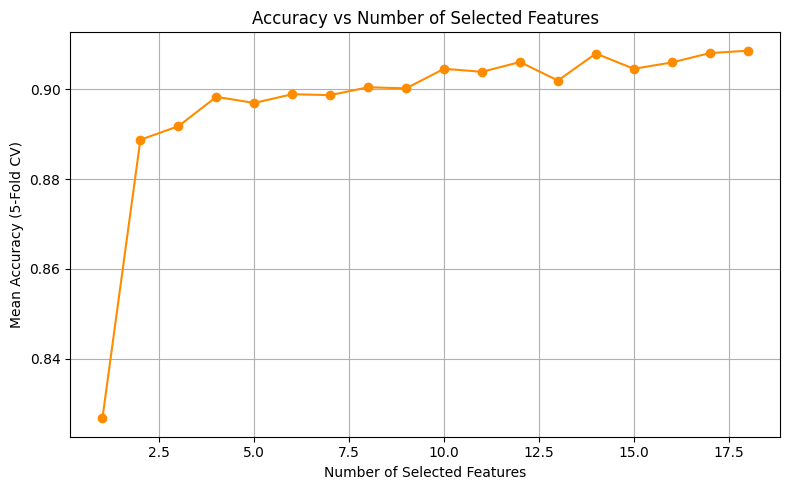

In [25]:
feature_counts = range(1, X.shape[1] + 1)
mean_accuracies = []

for n in feature_counts:
    rfe = RFE(estimator=dt, n_features_to_select=n)
    pipeline_dt = Pipeline([
        ('scaler', scaler),
        ('rfe', rfe),
        ('smote', smote),
        ('clf', dt)
    ])
    scores = cross_val_score(pipeline_dt, X, y, cv=cv, scoring='accuracy')
    mean_accuracies.append(scores.mean())

plt.figure(figsize=(8, 5))
plt.plot(feature_counts, mean_accuracies, marker='o', color='darkorange')
plt.xlabel('Number of Selected Features')
plt.ylabel('Mean Accuracy (5-Fold CV)')
plt.title('Accuracy vs Number of Selected Features')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# confusion matrix for RFE 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.35, random_state=42)
pipeline_dt.fit(X_train, y_train)
y_pred = pipeline_dt.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# LOW PRECISION AND RECALL TO BIAS TOWARDS MAJORITY CLASS

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      6136
           1       0.43      0.59      0.50       525
           2       0.78      0.76      0.77       560

    accuracy                           0.91      7221
   macro avg       0.73      0.77      0.74      7221
weighted avg       0.92      0.91      0.91      7221

[[5824  284   28]
 [ 122  310   93]
 [  10  123  427]]


In [33]:
# LETS TRY BALANCED RF
from sklearn.ensemble import RandomForestClassifier
rfe = RFE(estimator=dt, n_features_to_select=15)
smote = SMOTE(random_state=42)
scaler = StandardScaler()
clf = RandomForestClassifier(class_weight='balanced', random_state=42)

pipeline = Pipeline([
    ('scaler', scaler),
    ('rfe', rfe),
    ('smote', smote),
    ('clf', clf)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
print("Mean Accuracy:", scores.mean())

pipeline.fit(X, y)
top_features = X.columns[pipeline.named_steps['rfe'].get_support()]
print("Top selected features:")
print(top_features.tolist())


Mean Accuracy: 0.9256944766626172
Top selected features:
['cycle', 'altitude', 'T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRe', 'BPR', 'W31', 'W32']


In [ ]:
# confusion matrix for RFE and Balanced RF

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# ---SAME CASE AGAIN--

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      5260
           1       0.49      0.69      0.57       450
           2       0.85      0.88      0.86       480

    accuracy                           0.92      6190
   macro avg       0.77      0.84      0.80      6190
weighted avg       0.94      0.92      0.93      6190

[[4995  262    3]
 [  66  310   74]
 [   0   60  420]]


In [ ]:
# MODEL TRAINING
from sklearn.model_selection import train_test_split
# Split the data into training and Holdout sets 
X = data.drop(columns=['health','RUL','engine_id'])
y = data['Health_Index'] 
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)
X_train.shape, X_holdout.shape, y_train.shape, y_holdout.shape


((15473, 11), (5158, 11), (15473,), (5158,))

DISCREATIZATION 

In [ ]:
# Create the 3-class distribution in health_stage_code (BASED ON DOMAIN KNOWLEGE AND AERO-MECH RESEARCH)
# --THRESHOLDS CAN BE SUBJECTIVE--
# BUT these thresholds can also be acceptable in the project to avoid-- EXTREME CLASS IMBALANCE
data['health_stage_code'] = np.where(
    data['RUL'] < 25, 2,
    np.where(data['RUL'] < 50, 1, 0)
)


In [ ]:
data =data.drop(columns =["health_stage"])
data

In [52]:
data["health_stage_code"].value_counts()

health_stage_code
0    15631
1     2500
2     2500
Name: count, dtype: int64

In [62]:
# USING DIFFERENT APPROACH 
# APPLYING SMOTE BEFORE RFE AND TRAINING
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Step 1: Split first to maintain stratified sampling
X_full = data.drop(columns=[ "health_stage_code","engine_id"])
y_full = data["health_stage_code"]

# Split before SMOTE to avoid data leakage
X_train, _, y_train, _ = train_test_split(X_full, y_full, test_size=0.2, stratify=y_full, random_state=42)

# Step 2: Apply SMOTE (but keep k_neighbors high to prevent overfitting on minority class)
smote = SMOTE(random_state=42, sampling_strategy={1: 4000, 2: 4000})  # Keep class 0 unchanged--> since its majority
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Step 3: Combine / (+)
data_resampled = X_resampled.copy()
data_resampled["health_stage_code"] = y_resampled



In [63]:
data_resampled["health_stage_code"].value_counts()

health_stage_code
0    12504
1     4000
2     4000
Name: count, dtype: int64

In [67]:
# Feature Extraction 
# Using RFE (Recursive Feature Elimination / Decision Trees) after smote
X = data_resampled.drop(columns=["health_stage_code","RUL"]) 
y = data_resampled["health_stage_code"]

dt = DecisionTreeClassifier(random_state=42)
rfe = RFE(estimator=dt, n_features_to_select=15)  
scaler = StandardScaler()

# Pipeline
pipeline_dt = Pipeline([
    ('scaler', scaler),
    ('rfe', rfe),
    ('clf', dt)
]) 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline_dt, X, y, cv=cv, scoring='accuracy')
print(scores.mean())
pipeline_dt.fit(X, y)

feature_mask = pipeline_dt.named_steps['rfe'].get_support()
top_features = X.columns[feature_mask]

print("Top selected features:")
print(top_features.tolist())


0.8709520699888783
Top selected features:
['cycle', 'mach_number', 'T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRe', 'BPR', 'W31', 'W32']


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
pipeline_dt.fit(X_train, y_train)
y_pred = pipeline_dt.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      3126
           1       0.67      0.71      0.69      1000
           2       0.86      0.87      0.86      1000

    accuracy                           0.87      5126
   macro avg       0.82      0.83      0.83      5126
weighted avg       0.87      0.87      0.87      5126

[[2875  229   22]
 [ 173  707  120]
 [  11  122  867]]


In [ ]:
# LETS TRY BALANCED RF after smote
rfe = RFE(estimator=dt, n_features_to_select=15)
scaler = StandardScaler()
clf = RandomForestClassifier(class_weight='balanced', random_state=42)

pipeline = Pipeline([
    ('scaler', scaler),
    ('rfe', rfe),
    ('clf', clf)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
print("Mean Accuracy:", scores.mean())
pipeline.fit(X, y)
top_features = X.columns[pipeline.named_steps['rfe'].get_support()]
print("Top selected features:")
print(top_features.tolist())


Mean Accuracy: 0.9172355939360418
Top selected features:
['cycle', 'mach_number', 'T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRe', 'BPR', 'W31', 'W32']


In [70]:
# confusion matrix for RFE and Balanced RF

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.95      0.96      0.95      3752
           1       0.79      0.77      0.78      1200
           2       0.93      0.92      0.93      1200

    accuracy                           0.91      6152
   macro avg       0.89      0.88      0.89      6152
weighted avg       0.91      0.91      0.91      6152

[[3594  156    2]
 [ 190  928   82]
 [   5   90 1105]]


In [ ]:
from xgboost import XGBClassifier
# TRYING XGBOOST WITH RFE for FEATURE SELECTION
# XGBoost classifier
clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
rfe = RFE(estimator=clf, n_features_to_select=15)
# Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rfe', rfe),
    ('clf', clf)
])
# CROSS VALIDATION (KFOLD SPLIT / FOLD =5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
print("Mean Accuracy:", scores.mean())
pipeline.fit(X, y)
top_features = X.columns[pipeline.named_steps['rfe'].get_support()]
print("Top selected features:")
print(top_features.tolist())


Mean Accuracy: 0.9271851362844281
Top selected features:
['cycle', 'mach_number', 'T24', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRe', 'BPR', 'htBleed', 'W31', 'W32']


In [ ]:
# confusion matrix for RFE and XBOOST

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# WE CAN THE PRECISION and RECALL AUTOMATICALLY IMPROVED!
# WE DIDNT HAVE TO USE SMOTE OR OVERSAMPLING WITHIN VALIDATION 

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      3752
           1       0.81      0.80      0.80      1200
           2       0.94      0.92      0.93      1200

    accuracy                           0.92      6152
   macro avg       0.90      0.89      0.90      6152
weighted avg       0.92      0.92      0.92      6152

[[3606  144    2]
 [ 171  957   72]
 [   8   83 1109]]


C:\Users\elroy\AppData\Local\Temp\ipykernel_36464\1473620511.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations_target.values, y=correlations_target.index, palette='Blues')


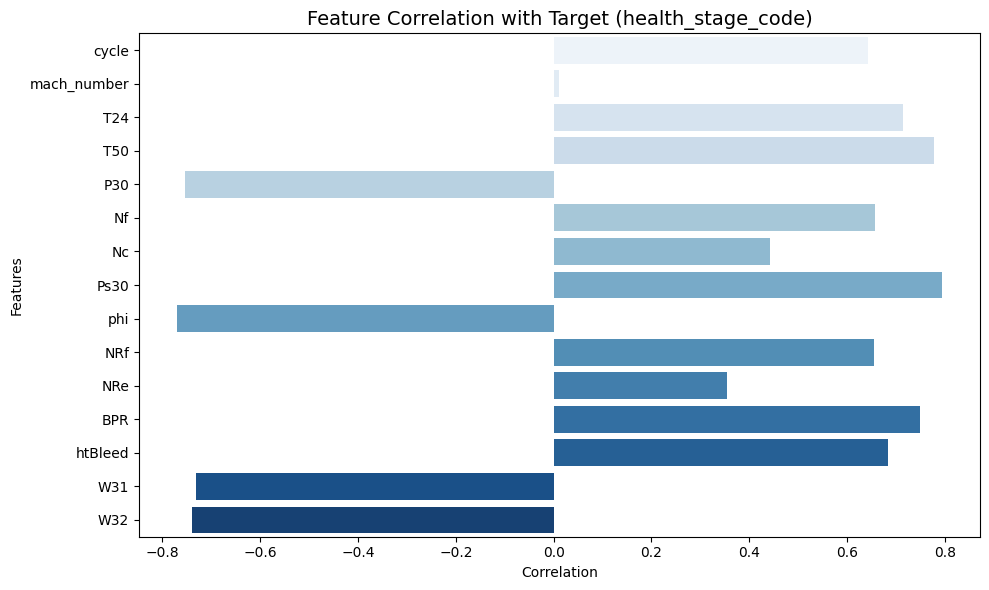

In [ ]:
# Subset only the selected features (+)  target (HSC)
# FILTER METHOD (PEARSON CORRELATION)
import seaborn as sns
selected_features = ['cycle', 'mach_number', 'T24', 'T50', 'P30', 'Nf', 'Nc', 
                     'Ps30', 'phi', 'NRf', 'NRe', 'BPR', 'htBleed', 'W31', 'W32', 'health_stage_code']

data_resampled = data_resampled[selected_features]

# Compute correlation with the target only
correlations_target = data_resampled.corr()['health_stage_code'].drop('health_stage_code')
# Plot correlation as a barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations_target.values, y=correlations_target.index, palette='Blues')
plt.title('Feature Correlation with Target (health_stage_code)', fontsize=14)
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.tight_layout()
plt.show() 


In [74]:
# REMOVE FEATURES THAT MEET THE THRESHOLD
# Select features with absolute correlation >= 0.5
selected_features = correlations_target[correlations_target.abs() >= 0.5].index.tolist()
selected_features.append('health_stage_code')
data_final = data_resampled[selected_features]
print("Selected features with |correlation| >= 0.5:")
print(selected_features)

Selected features with |correlation| >= 0.5:
['cycle', 'T24', 'T50', 'P30', 'Nf', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'W31', 'W32', 'health_stage_code']


In [75]:
data_final

,cycle,T24,T50,P30,Nf,Ps30,phi,NRf,BPR,htBleed,W31,W32,health_stage_code
0,26,642.460000,1399.510000,553.910000,2388.030000,47.430000,521.940000,2388.040000,8.435200,392,39.060000,23.365100,0
1,169,642.930000,1419.620000,552.630000,2388.110000,47.830000,520.430000,2388.080000,8.507100,395,38.570000,23.066800,1
2,135,642.510000,1407.120000,553.550000,2388.090000,47.450000,522.190000,2388.080000,8.424500,392,38.870000,23.295600,0
3,181,643.030000,1418.040000,552.250000,2388.160000,47.980000,520.800000,2388.200000,8.504000,395,38.900000,23.353300,2
4,166,642.980000,1405.590000,554.140000,2388.090000,47.320000,521.500000,2388.080000,8.428100,392,38.930000,23.209100,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20499,194,643.502964,1427.184833,551.451259,2388.178741,48.111482,520.359629,2388.122519,8.518794,396,38.360000,23.052505,2
20500,140,643.535139,1421.749868,551.859854,2388.192510,47.937530,520.225166,2388.214993,8.460894,394,38.662483,23.139548,2
20501,196,643.404701,1418.207897,553.155180,2388.101590,47.772103,520.967812,2388.087897,8.488021,395,38.548427,23.117465,2
20502,163,643.979360,1419.491784,552.340503,2388.189961,47.829837,520.640457,2388.110013,8.503382,395,38.699961,23.278912,2


In [76]:
# Prepare out data for model training and testing
# We will use the 75% of the data for training and validation and 25% for holdout testing 
# We will Kfold stratified cross validation for model training and validation 
from sklearn.model_selection import train_test_split
X = data_final.drop(columns=["health_stage_code"])
y = data_final["health_stage_code"]
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [83]:
y_train.value_counts()

health_stage_code
0    9378
2    3000
1    3000
Name: count, dtype: int64

# **STACKING ENSEMBLE CLASSIFICATION (META- lgb))**

In [ ]:
# IMPORT THE IMP MODULES

from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

base_learners = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42)),
    ('mlp', MLPClassifier(max_iter=1000, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))
]

meta_learner = LGBMClassifier(random_state=42)

stack = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=skf,
    n_jobs=-1
)

pipeline_stacking = ImbPipeline([
    ('scaler', StandardScaler()),
    ('stack', stack)
])
 # Fit the model 
pipeline_stacking.fit(X_train, y_train)

scores = cross_val_score(pipeline_stacking, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
print("Mean CV Accuracy:", scores.mean())


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2598
[LightGBM] [Info] Number of data points in the train set: 15378, number of used features: 15
[LightGBM] [Info] Start training from score -0.494571
[LightGBM] [Info] Start training from score -1.634326
[LightGBM] [Info] Start training from score -1.634326
Mean CV Accuracy: 0.8938742744774653


In [85]:
# confusion matrix for stacked ensemble
pipeline_stacking.fit(X_train, y_train)
y_pred = pipeline_stacking.predict(X_holdout)
print(classification_report(y_holdout, y_pred))
print(confusion_matrix(y_holdout, y_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2598
[LightGBM] [Info] Number of data points in the train set: 15378, number of used features: 15
[LightGBM] [Info] Start training from score -0.494571
[LightGBM] [Info] Start training from score -1.634326
[LightGBM] [Info] Start training from score -1.634326
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3126
           1       0.76      0.73      0.75      1000
           2       0.89      0.90      0.90      1000

    accuracy                           0.90      5126
   macro avg       0.87      0.86      0.86      5126
weighted avg       0.90      0.90      0.90      5126

[[2976  141    9]
 [ 168  734   98]
 [   7   92  901]]


#** STACKED ENSEMBLE (ANN AS META LEARNER)

In [86]:
# IMPORT REQUIRED MODULES
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
# STRATIFIED K-FOLD
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# DEFINE BASE LEARNERS
base_learners = [
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    ('gbc', GradientBoostingClassifier(random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('et', ExtraTreesClassifier(random_state=42))
]

# META-LEARNER: ANN
meta_learner = MLPClassifier(max_iter=1000, random_state=42)

# STACKING CLASSIFIER
stack2 = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=skf,
    n_jobs=-1
)

# DEFINE PIPELINE
pipeline_stacking2 = ImbPipeline([
    ('scaler', StandardScaler()),
    ('stack', stack2)
])

# FIT THE MODEL
pipeline_stacking2.fit(X_train, y_train)

# CROSS-VALIDATION SCORE
scores = cross_val_score(pipeline_stacking2, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
print("Mean CV Accuracy:", scores.mean())


Mean CV Accuracy: 0.9051893389154959


In [89]:
# confusion matrix for stacked ensemble
pipeline_stacking2.fit(X_train, y_train)
y_pred = pipeline_stacking2.predict(X_holdout)
print(classification_report(y_holdout, y_pred))
print(confusion_matrix(y_holdout, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3126
           1       0.77      0.78      0.78      1000
           2       0.92      0.91      0.91      1000

    accuracy                           0.91      5126
   macro avg       0.88      0.88      0.88      5126
weighted avg       0.91      0.91      0.91      5126

[[2976  144    6]
 [ 146  779   75]
 [   6   86  908]]


#**stacking but using 3 base learners and xgboost as meta

In [92]:
# STACKING BUT USING ONLY 3 BASE LEARNERS + XGBOOST AS META 
# base learner 1-  Random Forest
# base learner 2-  LightGBM 
# base learner 3-  SVM 
# Meta learner - XGBOOST
from sklearn.svm import SVC
from xgboost import XGBClassifier

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

base_learners = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42)),
    ('svm', SVC(kernel="rbf",probability=True, random_state=42))  # SVC needs probability=True
]

meta_learner = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
stack3 = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=skf,
    n_jobs=-1
)

pipeline_stacking3 = ImbPipeline([
    ('scaler', StandardScaler()),
    ('stack', stack3)
])
pipeline_stacking3.fit(X_train, y_train)
scores = cross_val_score(pipeline_stacking3, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
print("Mean CV Accuracy:", scores.mean())


Mean CV Accuracy: 0.8932890989247995


In [93]:
# confusion matrix for stacked ensemble
y_pred = pipeline_stacking3.predict(X_holdout)
print(classification_report(y_holdout, y_pred))
print(confusion_matrix(y_holdout, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3126
           1       0.76      0.74      0.75      1000
           2       0.90      0.89      0.90      1000

    accuracy                           0.90      5126
   macro avg       0.87      0.86      0.87      5126
weighted avg       0.90      0.90      0.90      5126

[[2980  137    9]
 [ 170  745   85]
 [   7  100  893]]


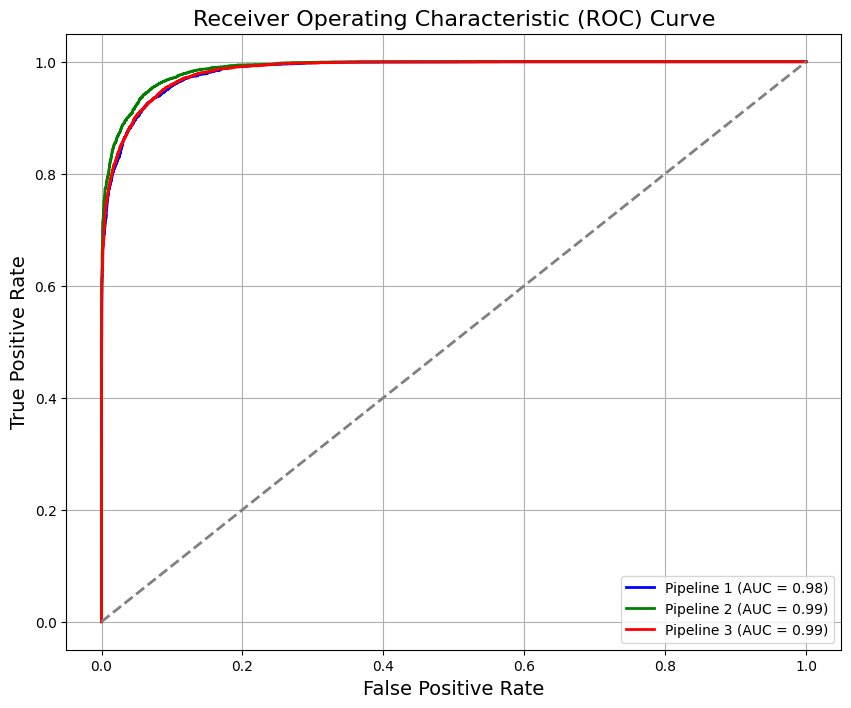

In [ ]:
# ROC_CURVE FOR STACKING 1 , 2, 3 
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


# Get predictions
y_pred1 = pipeline_stacking.predict_proba(X_holdout)
y_pred2 = pipeline_stacking2.predict_proba(X_holdout)
y_pred3 = pipeline_stacking3.predict_proba(X_holdout)

# Binarize the labels (for multi-class case)
y_test_bin = label_binarize(y_holdout, classes=[0, 1, 2])  # Modify based on your classes

# Initialize plot
plt.figure(figsize=(10, 8))

# Plot ROC curve for pipeline 1
fpr1, tpr1, _ = roc_curve(y_test_bin.ravel(), y_pred1.ravel())
roc_auc1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, color='blue', lw=2, label=f'Pipeline 1 (AUC = {roc_auc1:.2f})')

# Plot ROC curve for pipeline 2
fpr2, tpr2, _ = roc_curve(y_test_bin.ravel(), y_pred2.ravel())
roc_auc2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, color='green', lw=2, label=f'Pipeline 2 (AUC = {roc_auc2:.2f})')

# Plot ROC curve for pipeline 3
fpr3, tpr3, _ = roc_curve(y_test_bin.ravel(), y_pred3.ravel())
roc_auc3 = auc(fpr3, tpr3)
plt.plot(fpr3, tpr3, color='red', lw=2, label=f'Pipeline 3 (AUC = {roc_auc3:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
# SOFT VOTING ENSEMBLE TRAINING
from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Define classifiers
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
lgbm = LGBMClassifier(random_state=42)
bag = BaggingClassifier(random_state=42, bootstrap=True)

# Define parameter grids for hyperparameter tuning
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

lgbm_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'num_leaves': [20, 31, 40]
}

bag_param_grid = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.75, 1.0]
}
# GRID SEARCH 
xgb_grid_search = GridSearchCV(xgb, xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)
best_xgb = xgb_grid_search.best_estimator_

lgbm_grid_search = GridSearchCV(lgbm, lgbm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
lgbm_grid_search.fit(X_train, y_train)
best_lgbm = lgbm_grid_search.best_estimator_

bag_grid_search = GridSearchCV(bag, bag_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
bag_grid_search.fit(X_train, y_train)
best_bag = bag_grid_search.best_estimator_

# Soft voting ensemble with the best estimators
voting_multi = VotingClassifier(
    estimators=[('xgb', best_xgb), ('lgbm', best_lgbm), ('bag', best_bag)],
    voting='soft'
)

# fold=5
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(voting_multi, X_train, y_train, cv=cv, scoring='accuracy')

print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean cross-validation accuracy: {np.mean(cv_scores):.4f}")

voting_multi.fit(X_train, y_train)
y_pred = voting_multi.predict(X_holdout)


In [ ]:
#  MEAN ACCURACIES
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean cross-validation accuracy: {np.mean(cv_scores):.4f}")

Cross-validation accuracy scores: [0.90247074 0.89759428 0.90149545 0.90536585 0.90373984]
Mean cross-validation accuracy: 0.9021


In [101]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_holdout, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3126
           1       0.77      0.78      0.77      1000
           2       0.91      0.92      0.91      1000

    accuracy                           0.91      5126
   macro avg       0.88      0.88      0.88      5126
weighted avg       0.91      0.91      0.91      5126



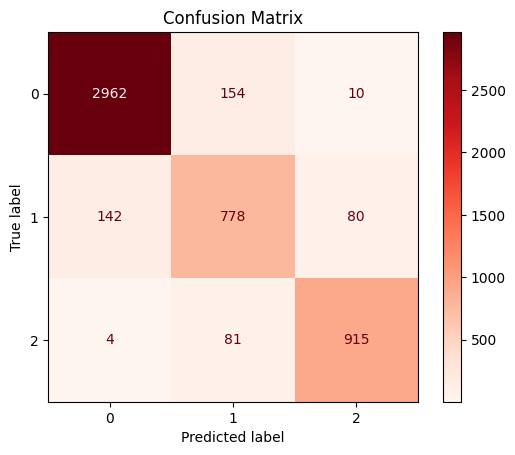

In [102]:
# VISUALIZATION
ConfusionMatrixDisplay.from_estimator(voting_multi, X_holdout, y_holdout, cmap='Reds')
plt.title("Confusion Matrix")
plt.show()

Overall AUC Score: 0.9802


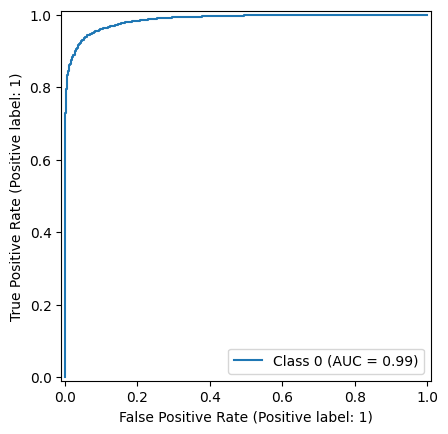

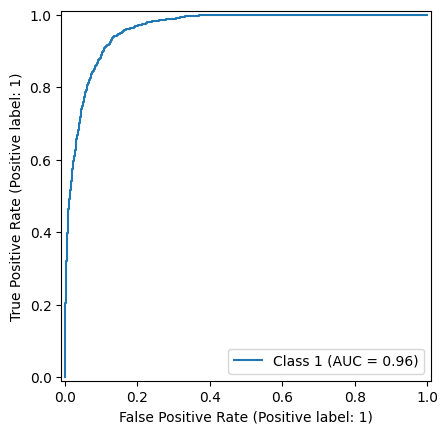

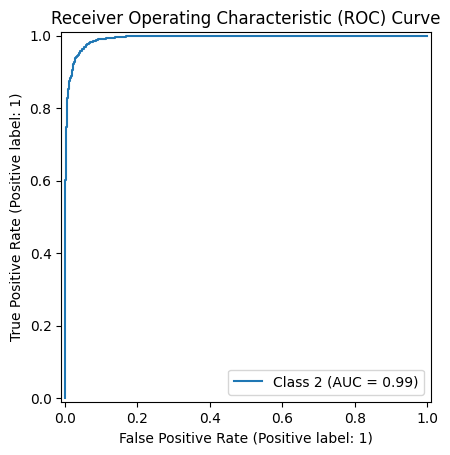

In [103]:
# roc curve for voting
from sklearn.metrics import  roc_auc_score
y_prob = voting_multi.predict_proba(X_holdout)
# Plot the ROC curve for each class
for i in range(y_prob.shape[1]):
    RocCurveDisplay.from_predictions(y_holdout == i, y_prob[:, i], name="Class " + str(i))
auc_score = roc_auc_score(y_holdout, y_prob, multi_class='ovr')
print("Overall AUC Score:", round(auc_score, 4))
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.show()

In [ ]:
# overfitting yes or no?
# AUC score on the training set
y_train_prob = voting_multi.predict_proba(X_train)
train_auc_score = roc_auc_score(y_train, y_train_prob, multi_class='ovr')
print("Training AUC Score:", train_auc_score)
print("Holdout AUC Score:", auc_score)  

Training AUC Score: 1.0
Holdout AUC Score: 0.9802362150946404


In [113]:
# LOOK THE TEST DATA
df001_test = pd.read_csv(r'C:\Users\elroy\OneDrive\Desktop\JetEngineFailureClassification\test_FD001.txt', sep='\s+', header=None)

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\elroy\AppData\Local\Temp\ipykernel_36464\2690015.py:2: SyntaxWarning: invalid escape sequence '\s'
  df001_test = pd.read_csv(r'C:\Users\elroy\OneDrive\Desktop\JetEngineFailureClassification\test_FD001.txt', sep='\s+', header=None)


In [114]:
columns = ['engine_id', 'cycle', 
           'altitude', 'mach_number', 'sea_level_temp', 
           'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 
           'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRe', 
           'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']

df001_test.columns = columns

In [115]:
# List of required columns
columns_to_include = ['cycle', 'T24', 'T50', 'P30', 'Nf', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'W31', 'W32']

# Ensure 'engine_id' is retained as the index
df001_test = df001_test.set_index('engine_id')[columns_to_include]
df001_test

,cycle,T24,T50,P30,Nf,Ps30,phi,NRf,BPR,htBleed,W31,W32
engine_id,,,,,,,,,,,,
1,1,643.02,1398.21,553.90,2388.04,47.20,521.72,2388.03,8.4052,392,38.86,23.3735
1,2,641.71,1395.42,554.85,2388.01,47.50,522.16,2388.06,8.3803,393,39.02,23.3916
1,3,642.46,1401.34,554.11,2388.05,47.50,521.97,2388.03,8.4441,393,39.08,23.4166
1,4,642.44,1406.42,554.07,2388.03,47.28,521.38,2388.05,8.3917,391,39.00,23.3737
1,5,642.51,1401.92,554.16,2388.01,47.31,522.15,2388.03,8.4031,390,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...
100,194,643.24,1415.79,553.41,2388.02,47.69,520.69,2388.00,8.4715,394,38.65,23.1974
100,195,643.22,1422.05,553.22,2388.05,47.60,521.05,2388.09,8.4512,395,38.57,23.2771
100,196,643.44,1406.82,553.04,2388.11,47.57,521.18,2388.04,8.4569,395,38.62,23.2051


In [ ]:
# Last cycle of the engine
df001_test_last = df001_test.groupby('engine_id').last()
df001_test_last

In [ ]:
df001_rul_test = pd.read_csv(r'RUL_FD001.txt', sep='\s+', header=None)
df001_rul_test = df001_rul_test.rename(columns={0: "RUL"})
df001_rul_test

In [ ]:
df001_test_last['RUL'] = df001_rul_test['RUL'].values
df001_test_last

In [126]:
df001_test_last['health_stage_code'] = np.where(
    df001_test_last['RUL'] < 25, 2,
    np.where(df001_test_last['RUL'] < 50, 1, 0)
)
df001_test_last

,cycle,T24,T50,P30,Nf,Ps30,phi,NRf,BPR,htBleed,W31,W32,RUL,health_stage_code
engine_id,,,,,,,,,,,,,,
1,31,642.58,1398.91,554.42,2388.08,47.23,521.79,2388.06,8.4024,393,38.81,23.3552,112,0
2,49,642.55,1410.83,553.52,2388.10,47.67,521.74,2388.09,8.4505,391,38.81,23.2618,98,0
3,126,642.88,1418.89,552.59,2388.16,47.88,520.83,2388.14,8.4119,395,38.93,23.2740,69,0
4,106,642.78,1406.88,552.64,2388.13,47.65,521.88,2388.11,8.4634,395,38.58,23.2581,82,0
5,98,642.27,1419.36,553.29,2388.10,47.46,521.00,2388.15,8.4362,394,38.75,23.4117,91,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,97,642.30,1397.94,553.99,2388.03,47.14,522.30,2388.01,8.4110,391,38.96,23.4606,137,0
97,134,642.59,1410.92,554.05,2388.06,47.38,521.58,2388.06,8.4500,395,38.61,23.2953,82,0
98,121,642.68,1415.47,553.44,2388.13,47.66,521.53,2388.09,8.4235,394,38.76,23.3608,59,0


In [127]:
df001_test_last["health_stage_code"].value_counts()

health_stage_code
0    70
2    19
1    11
Name: count, dtype: int64

In [ ]:
df001_test_last = df001_test_last.drop(columns=["RUL"])

In [129]:
# Split df001_test_last into features (X_unseen) and target (y_unseen)
X_unseen = df001_test_last.drop(columns=['health_stage_code'])  # Features
y_unseen = df001_test_last['health_stage_code']                # Target


In [ ]:
"""now we are testing stacking 1 ,2 ,3 and esemble voting on unseen data """
pipeline_stacking
pipeline_stacking2
pipeline_stacking3
voting_multi


StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('lgbm', LGBMClassifier(random_state=42)),
                               ('svm', SVC(probability=True, random_state=42))],
                   final_estimator=XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsa...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=42, ...),
                   n_jobs=-1)

Classification Report for Pipeline Stacking:

              precision    recall  f1-score   support

           0       0.94      0.91      0.93        70
           1       0.40      0.55      0.46        11
           2       0.88      0.79      0.83        19

    accuracy                           0.85       100
   macro avg       0.74      0.75      0.74       100
weighted avg       0.87      0.85      0.86       100

--------------------------------------------------
Classification Report for Pipeline Stacking 2:

              precision    recall  f1-score   support

           0       0.94      0.91      0.93        70
           1       0.40      0.55      0.46        11
           2       0.88      0.79      0.83        19

    accuracy                           0.85       100
   macro avg       0.74      0.75      0.74       100
weighted avg       0.87      0.85      0.86       100

--------------------------------------------------
Classification Report for Pipeline Stackin

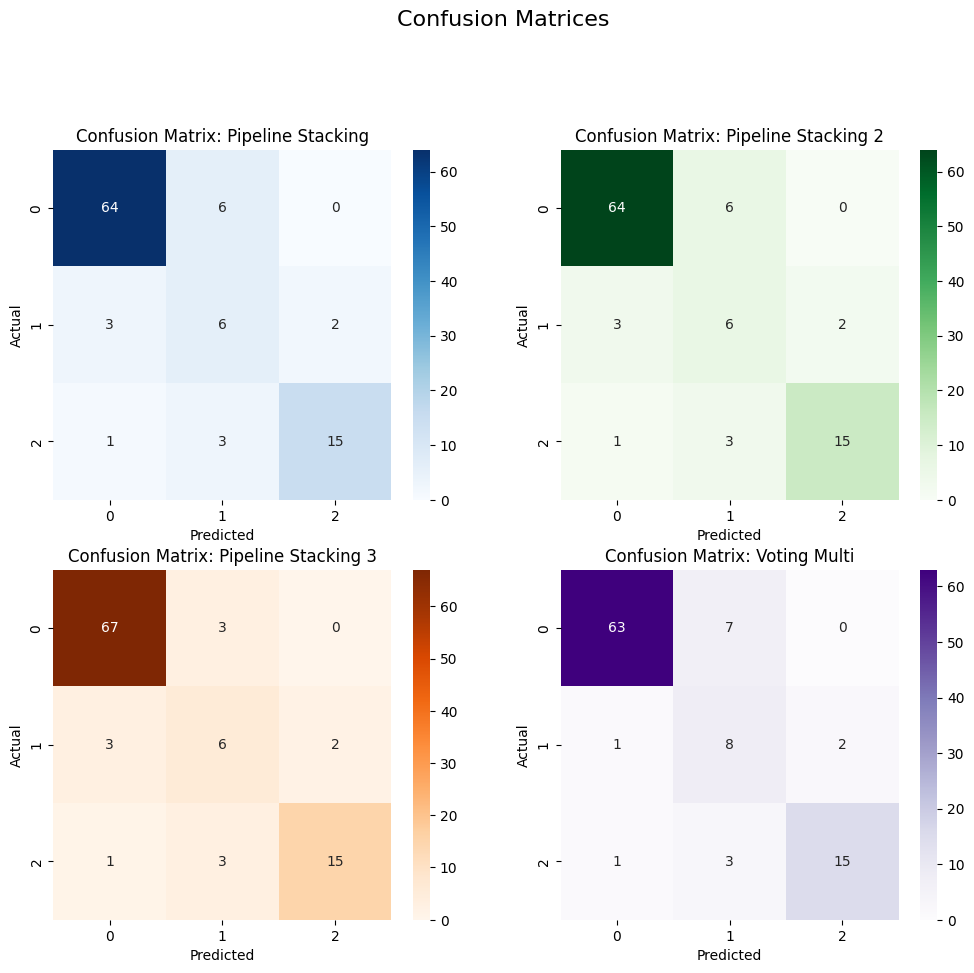

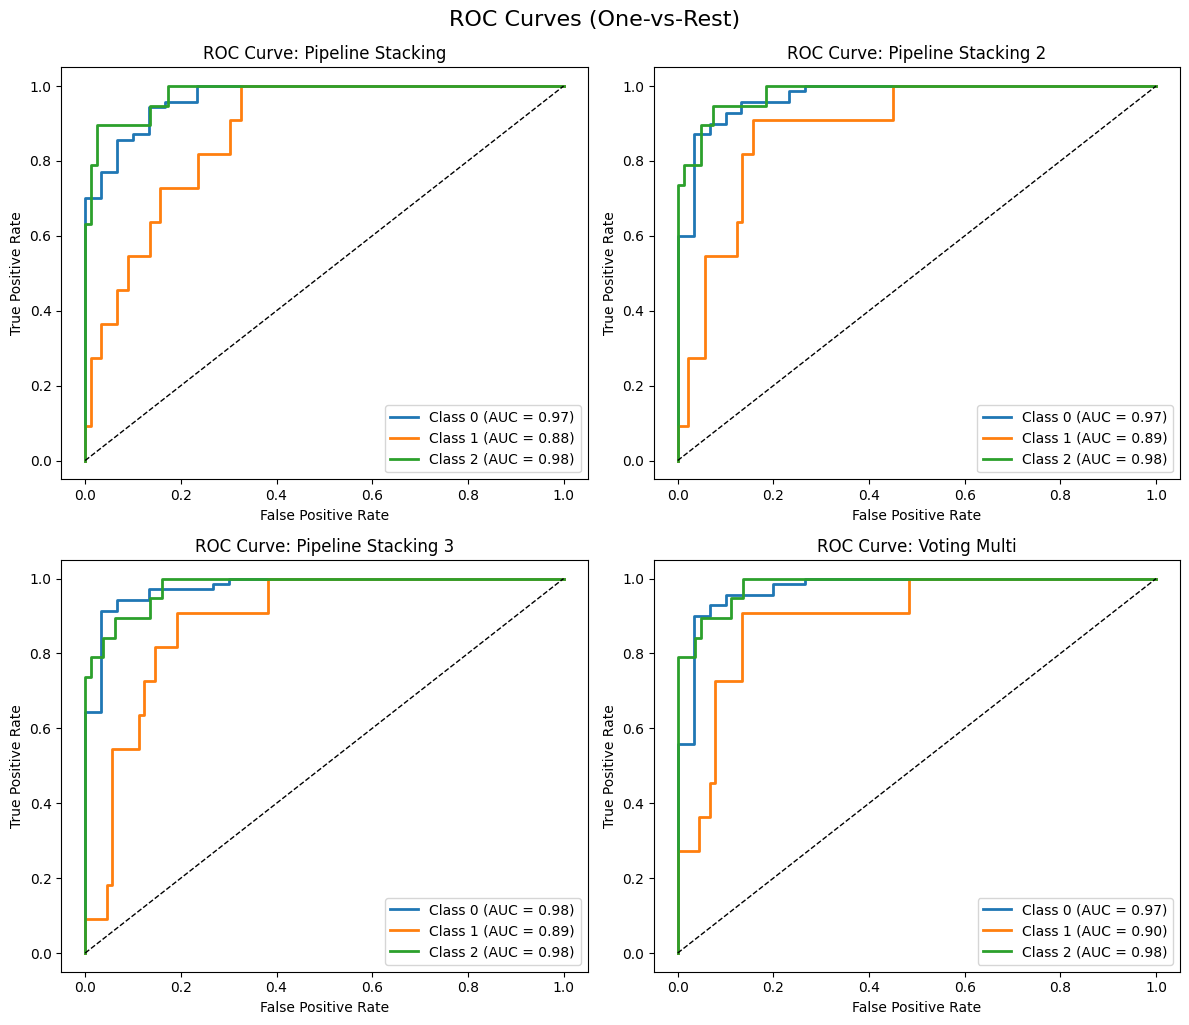

In [135]:
from sklearn.preprocessing import label_binarize

# Dictionary to store predictions and model names
models = {
    "Pipeline Stacking": pipeline_stacking,
    "Pipeline Stacking 2": pipeline_stacking2,
    "Pipeline Stacking 3": pipeline_stacking3,
    "Voting Multi": voting_multi
}

# Binarize the labels for multiclass ROC
classes = sorted(y_unseen.unique())  # List of unique classes
y_unseen_bin = label_binarize(y_unseen, classes=classes)

# Initialize subplots for confusion matrices and ROC curves
fig_cm, axes_cm = plt.subplots(2, 2, figsize=(12, 10))  # Confusion Matrices
fig_roc, axes_roc = plt.subplots(2, 2, figsize=(12, 10))  # ROC Curves

# Flatten axes for easier iteration
axes_cm = axes_cm.ravel()
axes_roc = axes_roc.ravel()

# Unique color palettes for confusion matrices
cm_colors = ['Blues', 'Greens', 'Oranges', 'Purples']

# Loop through models and evaluate
for idx, (name, model) in enumerate(models.items()):
    # Generate predictions and probabilities
    y_pred = model.predict(X_unseen)
    y_prob = model.predict_proba(X_unseen) if hasattr(model, "predict_proba") else None

    # Plot Confusion Matrix
    cm = confusion_matrix(y_unseen, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cm_colors[idx % len(cm_colors)], ax=axes_cm[idx])
    axes_cm[idx].set_title(f"Confusion Matrix: {name}")
    axes_cm[idx].set_xlabel("Predicted")
    axes_cm[idx].set_ylabel("Actual")

    # Print Classification Report
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_unseen, y_pred))
    print("-" * 50)

    # Plot ROC Curve (if probabilities are available)
    if y_prob is not None:
        for i, class_name in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_unseen_bin[:, i], y_prob[:, i])
            roc_auc = auc(fpr, tpr)
            axes_roc[idx].plot(fpr, tpr, label=f"Class {class_name} (AUC = {roc_auc:.2f})", linewidth=2)

        # Add diagonal line and legend
        axes_roc[idx].plot([0, 1], [0, 1], 'k--', linewidth=1)
        axes_roc[idx].set_title(f"ROC Curve: {name}")
        axes_roc[idx].set_xlabel("False Positive Rate")
        axes_roc[idx].set_ylabel("True Positive Rate")
        axes_roc[idx].legend(loc="lower right")

# Adjust layout and display
plt.tight_layout()
fig_cm.suptitle("Confusion Matrices", fontsize=16, y=1.02)
fig_roc.suptitle("ROC Curves (One-vs-Rest)", fontsize=16, y=1.02)
plt.show()

In [136]:
# LOAD THE FILES TO SYSTEM
import pickle
# Save the models as pickle files
with open("Multi-class-Stacking1.pkl", "wb") as f:
    pickle.dump(pipeline_stacking, f)

with open("Multi-class-Stacking2.pkl", "wb") as f:
    pickle.dump(pipeline_stacking2, f)

with open("Multi-class-Stacking3.pkl", "wb") as f:
    pickle.dump(pipeline_stacking3, f)

with open("Voting-Multi.pkl", "wb") as f:
    pickle.dump(voting_multi, f)
